# Libs

In [1]:
import PIL
import PIL.Image as Image
import cv2

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
images_folder = './drive/MyDrive/ColabNotebooks/StyleTransfer/images/'

In [3]:
im_size = 256

# Functions

In [ ]:
# function for a gram matrix operation
def gram_transfer(m):
    result = tf.linalg.einsum('bijc,bijd->bcd', m, m)
    gram = tf.expand_dims(result, axis=0)
    shape = tf.shape(m)
    i_j = tf.cast(shape[1]*shape[2], tf.float32)
    return gram/i_j

In [ ]:
# make a model from convolutional layers of the base_model
K.clear_session()

base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(im_size,im_size,3),
    include_top=False
)

def make_Vgg_Net():
    
    vgg_layers = []
    for layer in base_model.layers:
        if "conv" in layer.name:
            layer.trainable = False
            vgg_layers.append(layer.output)
    model = keras.models.Model([base_model.input], [vgg_layers])
    return model

In [ ]:
def get_loss(content, style, target):
    
    x = 0.4

    content_l = vgg(content)[0]
    style_l = vgg(style)[0]
    target_l = vgg(tf.reshape(target, [1,im_size,im_size,3]))[0]
    
    loss_ct, loss_st = 0, 0
    num_of_layers = len(content_l)
    for c,s,t in zip(content_l, style_l, target_l):
        loss_ct += tf.reduce_mean((c - t)**2)
        s = gram_transfer(s)
        t = gram_transfer(t)
        loss_st += tf.reduce_mean((s - t)**2)
    loss = x*loss_ct + (1-x)*loss_st
    
    return loss/num_of_layers

In [ ]:
def get_img(path, size):
    img = PIL.Image.open(path)
    img = img.resize((size, size))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array/255.0
    return tf.convert_to_tensor(img_array)

# Get_image

In [ ]:
content_img = get_img(images_folder+'walkingdog.jpeg', im_size)
style_img = get_img(images_folder+'saryan.jpg', im_size)
target_img = tf.Variable([style_img])

In [ ]:
style_img.shape, content_img.shape, target_img.shape

(TensorShape([1, 256, 256, 3]),
 TensorShape([1, 256, 256, 4]),
 TensorShape([1, 1, 256, 256, 3]))

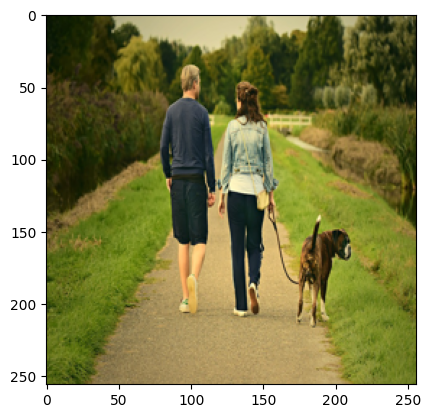

In [ ]:
# content
plt.imshow(content_img[0])
plt.savefig(images_folder+"walkingdog.png")

In [ ]:
# style
plt.savefig(images_folder+"saryan.png")

# model

In [ ]:
vgg = make_Vgg_Net()

In [ ]:
starting_time = time.time()
epochs = 8000
opt = tf.optimizers.Adam(learning_rate=1e-4)
loss_collection= []
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = get_loss(content_img, style_img, target_img)
    gradient = tape.gradient(loss, target_img)
    opt.apply_gradients([(gradient, target_img)])
    target_img.assign(tf.clip_by_value(target_img, clip_value_min=0.0, clip_value_max=1.0))
    if epoch % 500 ==0:
        tf.print(f"Loss = {round(float(loss), 3)} {epoch}")
    loss_collection.append(loss)
print("time spent: ", (time.time()-starting_time)/60)

Loss = 11.679 0
Loss = 9.575 500
Loss = 8.093 1000
Loss = 7.043 1500
Loss = 6.307 2000
Loss = 5.763 2500
Loss = 5.346 3000
Loss = 5.019 3500
Loss = 4.758 4000
Loss = 4.554 4500
Loss = 4.398 5000
Loss = 4.276 5500
Loss = 4.178 6000
Loss = 4.1 6500
Loss = 4.036 7000
Loss = 3.983 7500
time spent:  22.914583293596902


Text(0.5, 0, 'epoch')

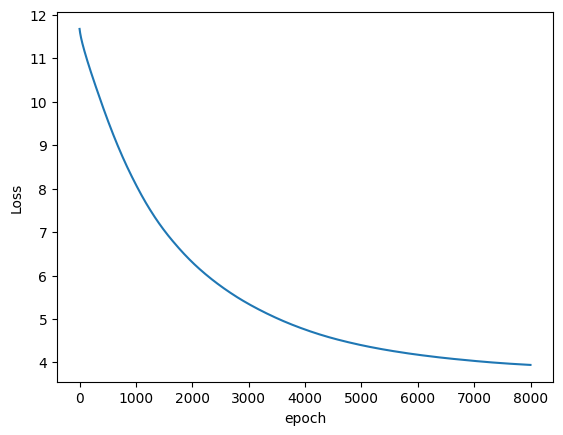

In [ ]:
plt.plot(loss_collection[:])
plt.ylabel("Loss")
plt.xlabel("epoch")

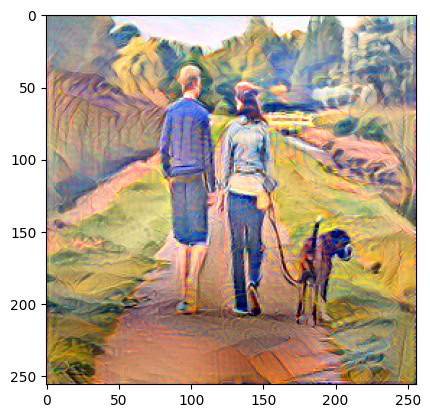

In [ ]:
# final output
plt.imshow(tf.reshape(target_img, [im_size,im_size,3]))
plt.savefig(images_folder+"walk_daryan.png")

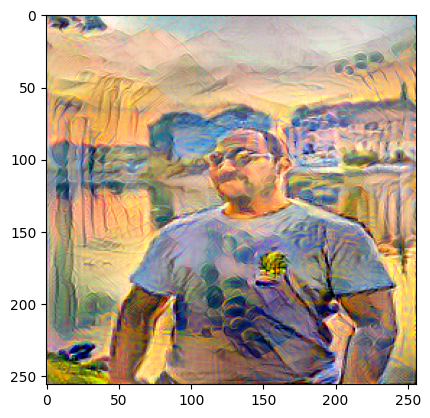

In [ ]:
# happy me